In [ ]:
# figpath = '/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/figures'

# Import required modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import celltypist
from celltypist import models

import scipy

import scanpy.external as sce

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120)

# Prepare functions

# Read in anndata

In [5]:
adata_vis = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad')

# subset OCT data
adata_vis = adata_vis[adata_vis.obs['modality']=='Visium']

# log-normalise
sc.pp.filter_genes(adata_vis, min_cells=3)
sc.pp.normalize_total(adata_vis, target_sum=1e4)
sc.pp.log1p(adata_vis)

adata_vis

AnnData object with n_obs × n_vars = 19590 × 22806
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts'

In [6]:
adata_vis.var_names_make_unique()

In [7]:
# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_vis.obs['annotation_final_mod']=adata_vis.obs['annotation_final'].astype('str').copy()
adata_vis.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_vis.obs['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].astype('category')

#reorder annotations
annotations_order = [
   'Atrium',
        'Ventricle - Compact',
     'Ventricle - Trabeculated',
        'SAnode',
        'AVnode',
    'VCS - Proximal',
        'VCS - Distal',
        'Great vessel',
        'Coronary vessel',
    'Ductus arteriosus',
        'Adventitia - Coronary',
     'Adventitia - GV',
    'Epicardium',
        'Endocardium - Atrial', 
    'Endocardium - Ventricular',
        'Endocardial cusion',
        'AV ring',
    'Valves',
  #   'LN',
            ]
adata_vis.obs['annotation_final_mod'].cat.reorder_categories(annotations_order, inplace=True)

In [8]:
# check spot
adata_vis.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          6294
Great vessel                 2871
Ventricle - Trabeculated     2437
Atrium                       1869
Endocardium - Ventricular    1800
Epicardium                   1092
Adventitia - GV               879
VCS - Distal                  670
Adventitia - Coronary         411
Endocardium - Atrial          318
VCS - Proximal                245
Valves                        237
AV ring                       196
Ductus arteriosus              71
Endocardial cusion             64
AVnode                         58
Coronary vessel                51
SAnode                         27
Name: annotation_final_mod, dtype: int64

# Read in index spots

In [11]:
# read in saved indices
indices = utils.read_pkl('/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_index_spots.pkl')

# concatenate dictionary
indices_conc = []
for cells in indices.values():
    indices_conc = indices_conc + cells
if len(indices_conc) == len(set(indices_conc)):
    print(f'total spot number: {len(indices_conc)}')
else:
    print('ERROR: spot indices are duplicated')

total spot number: 1186


In [14]:
# prepare train data
adata_train = adata_vis[indices_conc]

# check spot number of each structure
adata_train.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          95
Great vessel                 93
Atrium                       92
Endocardium - Ventricular    90
Epicardium                   82
Ventricle - Trabeculated     81
Adventitia - GV              75
Ductus arteriosus            71
VCS - Distal                 69
Endocardial cusion           64
Adventitia - Coronary        62
AVnode                       58
Endocardium - Atrial         57
Coronary vessel              51
Valves                       48
VCS - Proximal               38
AV ring                      33
SAnode                       27
Name: annotation_final_mod, dtype: int64

# Training CellTypist model

In [11]:
groupby = 'annotation_final_mod'

In [15]:
%%time
# train with all genes
model = celltypist.train(adata_train, # all genes
                         labels = groupby,
                         n_jobs = 10,
                         feature_selection = False, # since manually selected
                         check_expression = False
                        )
# Save the model
model.write(f'/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/traindata_model_all-index-spots.pkl')

🍳 Preparing data before training
✂️ 2027 non-expressed genes are filtered out
🔬 Input data has 1186 cells and 20779 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


CPU times: user 741 ms, sys: 127 ms, total: 867 ms
Wall time: 28.6 s


In [ ]:
increase max_iter
feature selection
celltypist fiture selectiuon = True

# Predict test data: non-index-spots

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [13]:
# prepare test data
adata_test = adata_vis[adata_vis.obs_names.isin(indices_conc)==False]

# check spot number of each structure
adata_test.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          6199
Great vessel                 2778
Ventricle - Trabeculated     2356
Atrium                       1777
Endocardium - Ventricular    1710
Epicardium                   1010
Adventitia - GV               804
VCS - Distal                  601
Adventitia - Coronary         349
Endocardium - Atrial          261
VCS - Proximal                207
Valves                        189
AV ring                       163
Name: annotation_final_mod, dtype: int64

# ROC curves

In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

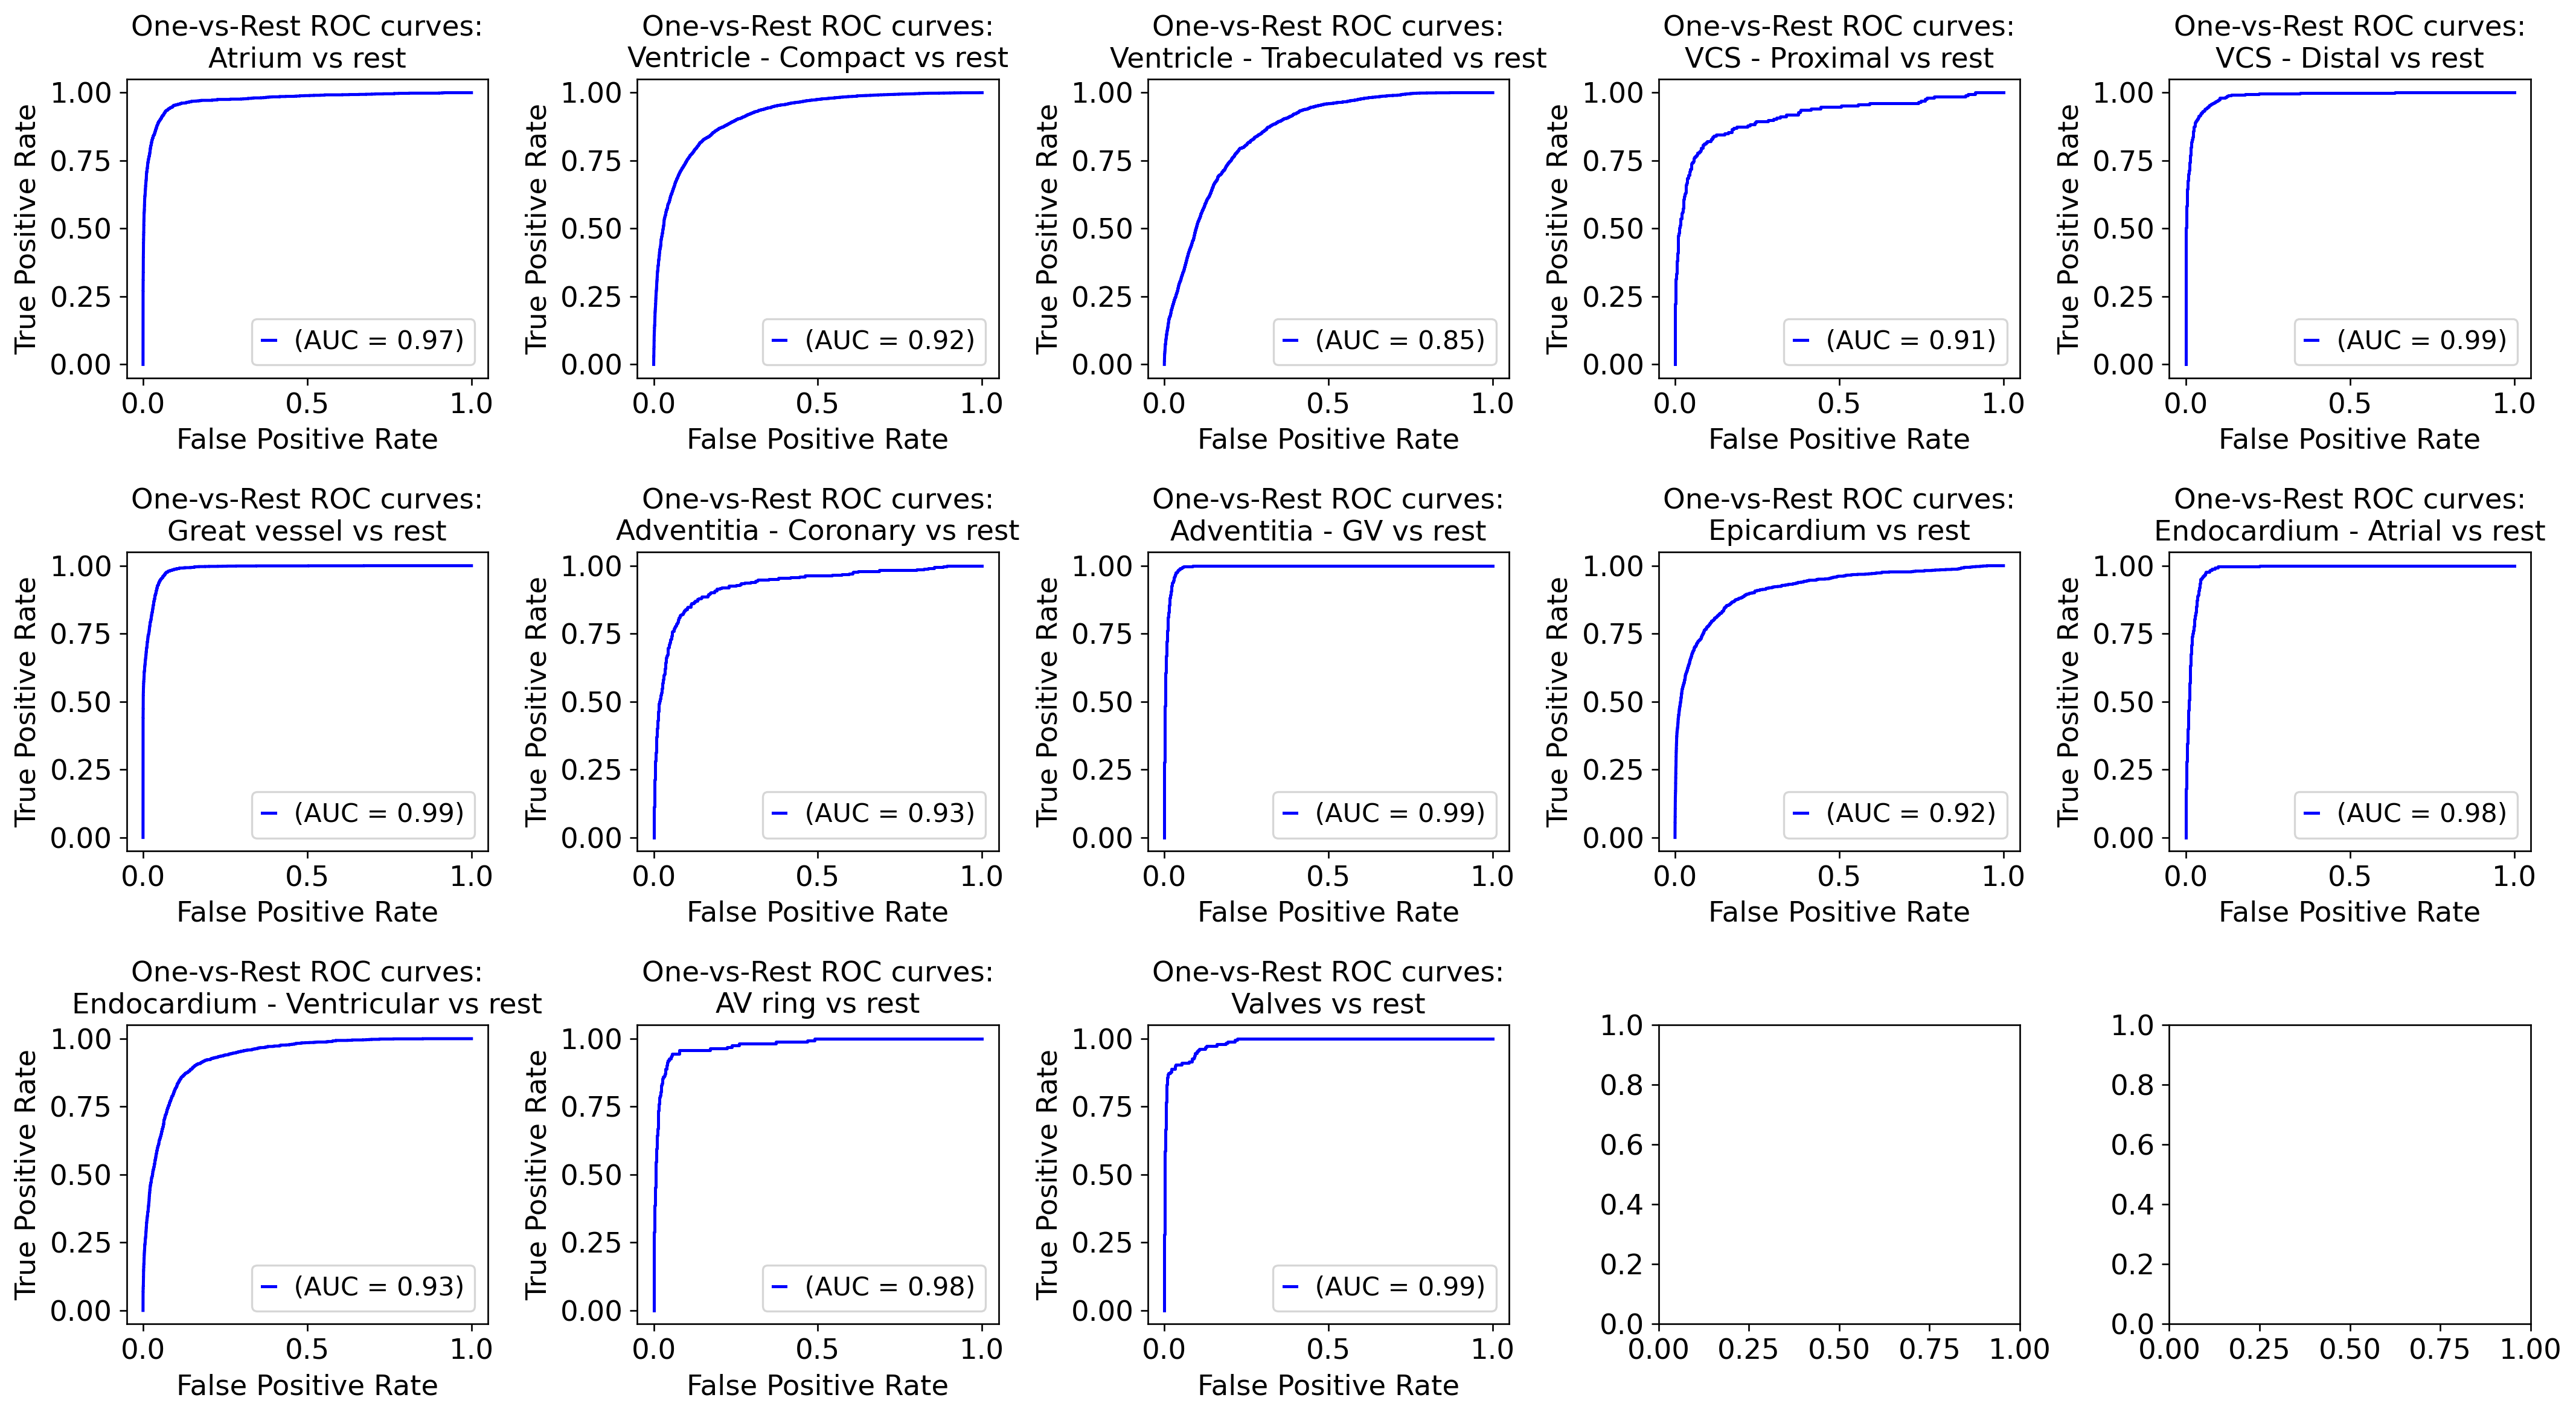

In [20]:
label_binarizer = LabelBinarizer().fit(adata_test.obs['annotation_final_mod'])
y_onehot_test = label_binarizer.transform(adata_test.obs['annotation_final_mod'])
# y_onehot_test.shape  # (n_samples, n_classes)

y_score = prediction.probability_matrix.copy()
y_score = y_score.loc[adata_test.obs_names,label_binarizer.classes_].to_numpy()

# plot
# prepare figure
nrows = 3
ncols = 5
fig,axs=plt.subplots(nrows=nrows,ncols=ncols,figsize=(18,10)) 

for i,class_of_interest in enumerate([x for x in annotations_order if x in list(set(adata_test.obs['annotation_final_mod']))]):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name='', # f"{class_of_interest} vs the rest",
        color='blue',
        plot_chance_level=False,
        ax=axs[i//ncols,i%ncols]
    )
    # axs[i//ncols,i%ncols].set_axis("square")
    axs[i//ncols,i%ncols].set_xlabel("False Positive Rate")
    axs[i//ncols,i%ncols].set_ylabel("True Positive Rate")
    axs[i//ncols,i%ncols].set_title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs rest")
    axs[i//ncols,i%ncols].legend()
fig.tight_layout()

In [19]:
label_binarizer.transform(adata_test.obs['annotation_final_mod'])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])